# **Group Members**
### Hamza Tariq                 20K-0198
### Ahmed Umer Siddiqui         20k-1736
### Zain Vohra                  20K-1712

#**Dataset: Plants Classification**
# **Approach: Ensemble Learning**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/csv/Copy of Datasets.zip"

In [3]:
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
img = cv2.imread("/content/Datasets/Plant Dataset/Healthy Plant/IMG_20231122_145657681_BURST0001_COVER.jpg")

An Example of a Healthy Plant

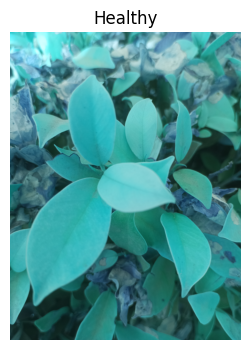

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title('Healthy')
plt.axis('off')
plt.show()


An example of an unhealthy plant

In [ ]:
img2 = cv2.imread("/content/Datasets/Plant Dataset/Unhealthy Plant/IMG_20231122_150247977_BURST0001_COVER.jpg")

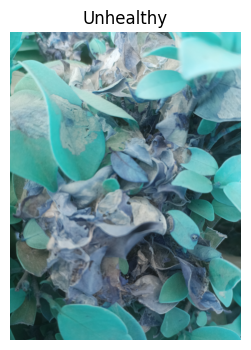

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.imshow(img2)
plt.title('Unhealthy')
plt.axis('off')
plt.show()


# Annotations

## Using a CSV to properly handle all the images and their labels

In [7]:
import os
import pandas as pd


In [8]:
import json


def generate_keypoints(img, label):
    height, width, _ = img.shape
    if label == 'healthy':
        keypoints = [(0, 0), (width, 0), (0, height), (width, height)]
        color = (0, 255, 0)  # Green color
    elif label == 'unhealthy':
        keypoints = [(0, 0), (50, 0), (0, 50), (50, 50)]
        color = (0, 0, 255)  # Red color
    else:
        keypoints = [(0, 0), (width, 0), (0, height), (width, height)]
        color = (255, 255, 255)  # Default color: White

    return keypoints, color

def save_annotations(annotations, annotation_file):
    with open(annotation_file, 'w') as f:
        json.dump(annotations, f, indent=2)

def read_images_and_create_df(folder_path, label):
    data = []
    for image_file in os.listdir(folder_path):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
            image_path = os.path.join(folder_path, image_file)
            data.append({'Image': image_path, 'Label': label})
    return data

def annotate_images(df, annotation_file):
    annotations = {}
    for index, row in df.iterrows():
        image_path = row['Image']
        label = row['Label']
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        keypoints, _ = generate_keypoints(img, label)
        annotations[image_path] = {'Label': label, 'Keypoints': keypoints}

    save_annotations(annotations, annotation_file)

healthy_folder_path = '/content/Datasets/Plant Dataset/Healthy Plant'
unhealthy_folder_path = '/content/Datasets/Plant Dataset/Unhealthy Plant'

healthy_data = read_images_and_create_df(healthy_folder_path, label='healthy')
unhealthy_data = read_images_and_create_df(unhealthy_folder_path, label='unhealthy')

all_data = healthy_data + unhealthy_data
df = pd.DataFrame(all_data)

annotation_file = 'annotations.json'
annotate_images(df, annotation_file)
df


,Image,Label
0,/content/Datasets/Plant Dataset/Healthy Plant/...,healthy
1,/content/Datasets/Plant Dataset/Healthy Plant/...,healthy
2,/content/Datasets/Plant Dataset/Healthy Plant/...,healthy
3,/content/Datasets/Plant Dataset/Healthy Plant/...,healthy
4,/content/Datasets/Plant Dataset/Healthy Plant/...,healthy
...,...,...
955,/content/Datasets/Plant Dataset/Unhealthy Plan...,unhealthy
956,/content/Datasets/Plant Dataset/Unhealthy Plan...,unhealthy
957,/content/Datasets/Plant Dataset/Unhealthy Plan...,unhealthy
958,/content/Datasets/Plant Dataset/Unhealthy Plan...,unhealthy


# **Preprocessing**

In [ ]:
import math
target_size=224
def preprocess():
  images = []
  labels = []

  for index, row in df.iterrows():
      img = cv2.imread(row['Image'])
      if img is not None:
        l=row['Label']

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_height, img_width = img.shape[:2]

        aspect = img_width / img_height

        if img_height > img_width:
            new_height = target_size
            new_width = int(round(target_size * aspect))
        else:
            new_width = target_size
            new_height = int(round(target_size / aspect))

        resize_factor = math.sqrt(
            (img_width**2 + img_height**2) / (new_width**2 + new_height**2)
        )

        img = cv2.resize(img, (new_width, new_height))

        pad_x = target_size - new_width
        pad_y = target_size - new_height

        pad_top, pad_bottom = [int(i) for i in np.floor([pad_y, pad_y]) / 2]
        pad_left, pad_right = [int(i) for i in np.floor([pad_x, pad_x]) / 2]

        img = cv2.copyMakeBorder(
            img,
            pad_top,
            pad_bottom,
            pad_left,
            pad_right,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0],
        )

        img = cv2.resize(img, (target_size, target_size))


        images.append(img)
        labels.append(l)
        if(index!=0 and index%100==0):
          print("A 100 pictures done\n")

  return images, labels

final_images, final_labels = preprocess()





A 100 pictures done

A 100 pictures done

A 100 pictures done

A 100 pictures done

A 100 pictures done

A 100 pictures done

A 100 pictures done

A 100 pictures done

A 100 pictures done



### Mapping labels to classes

In [ ]:
label_mapping = {'healthy':1, 'unhealthy':0}
final_labels = [label_mapping[label] for label in final_labels]

# Splitting the dataset and augmentation

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(final_images, final_labels, test_size = 0.2, random_state = 21)

datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 35,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_datagen = datagen.flow(
    np.array(train_images), np.array(train_labels), batch_size=32, shuffle=True
)

val_datagen = datagen.flow(
    np.array(val_images), np.array(val_labels), batch_size=32, shuffle=False
)

An overview how our dataset looks like now

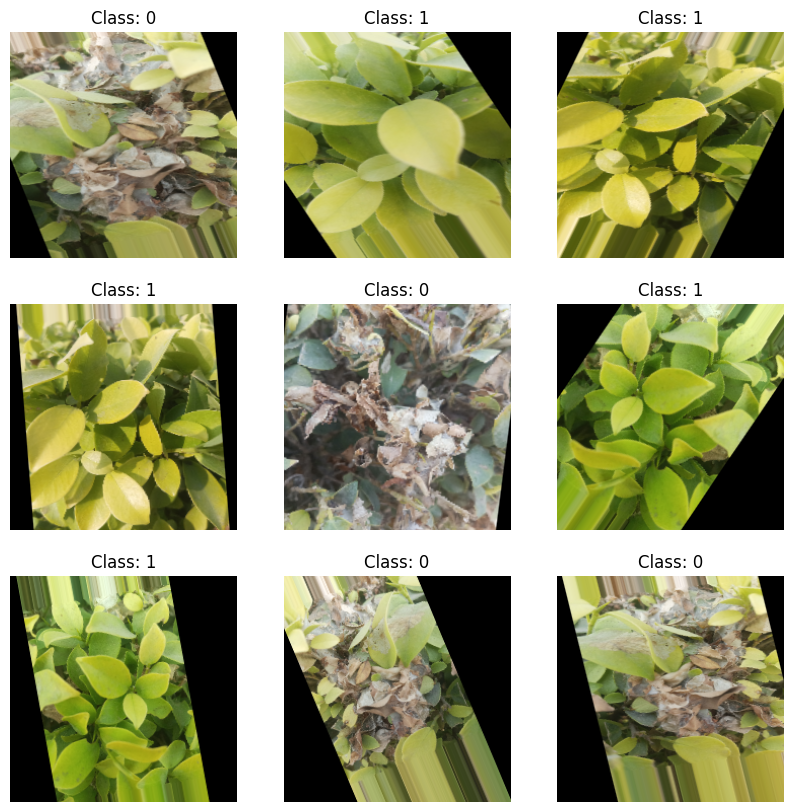

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images, augmented_labels = next(train_datagen)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0])
    plt.title(f'Class: {augmented_labels[0]}')
    plt.axis('off')

# **Model Preparation: VGG16**

Upon previous attempts, signs of overfitting were observed; hence, some approaches are being taken to avoid such circumstances such as dropout for regularlization and early stopping.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout


vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the convolutional layers so they won't be retrained
for layer in vgg_model.layers:
    layer.trainable = False


model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization
model.add(Dense(1, activation='sigmoid'))  #using sigmoid due to binary classification


model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])




model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# Training the model

In [ ]:
trained = model.fit(
    train_datagen,
    steps_per_epoch=len(train_images) // 32,
    epochs=20,
    validation_data=val_datagen,
    validation_steps=len(val_images) // 32,
    callbacks=[early_stopping],  #early stopping callback
    verbose=1
)

Epoch 1/20
24/24 [==============================] - 24s 554ms/step - loss: 0.0757 - accuracy: 0.9727 - val_loss: 9.9054e-07 - val_accuracy: 1.0000
Epoch 2/20
24/24 [==============================] - 14s 577ms/step - loss: 0.0022 - accuracy: 0.9987 - val_loss: 1.9041e-05 - val_accuracy: 1.0000
Epoch 3/20
24/24 [==============================] - 13s 539ms/step - loss: 0.0095 - accuracy: 0.9974 - val_loss: 1.6218e-07 - val_accuracy: 1.0000
Epoch 4/20
24/24 [==============================] - 13s 551ms/step - loss: 0.0143 - accuracy: 0.9974 - val_loss: 1.3469e-08 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 13s 542ms/step - loss: 0.0065 - accuracy: 0.9987 - val_loss: 2.7112e-09 - val_accuracy: 1.0000
Epoch 6/20
24/24 [==============================] - 14s 586ms/step - loss: 2.3811e-04 - accuracy: 1.0000 - val_loss: 1.9466e-11 - val_accuracy: 1.0000
Epoch 7/20
24/24 [==============================] - 14s 584ms/step - loss: 6.1269e-07 - accuracy: 1.0000 - val_los

Training has stopped at 14 epochs to avoid overfitting

### An overview to evaluate our model:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

val_images = np.array(val_images) / 255.0

predictions = model.predict(val_images)

binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]


accuracy = accuracy_score(val_labels, binary_predictions)
precision = precision_score(val_labels, binary_predictions)
recall = recall_score(val_labels, binary_predictions)
f1 = f1_score(val_labels, binary_predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

6/6 [==============================] - 1s 129ms/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


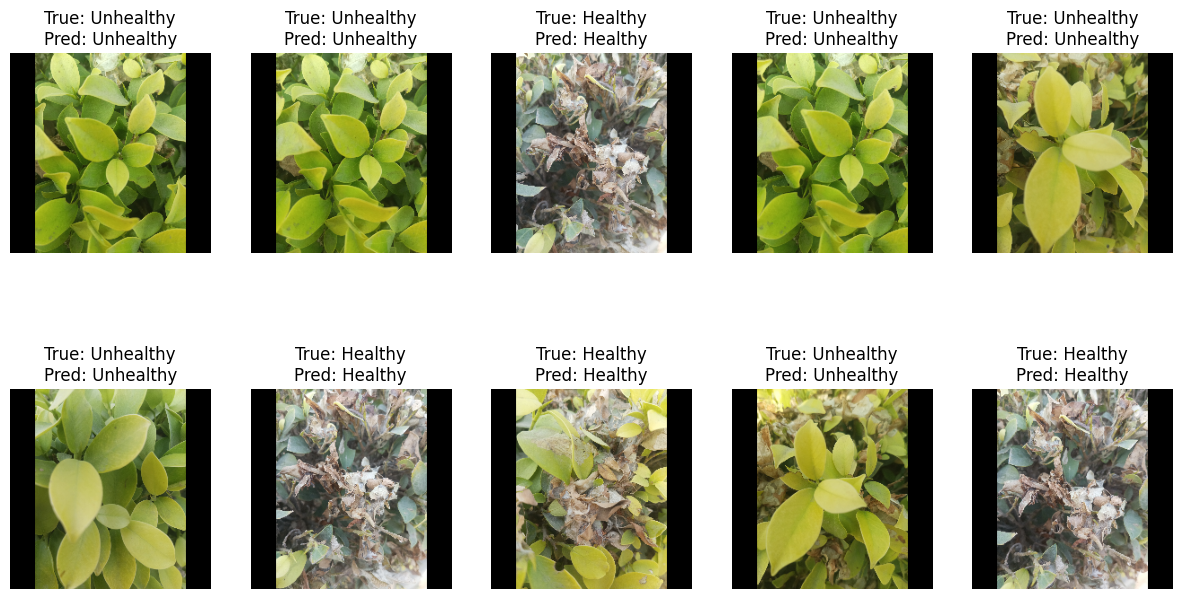

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images[i])
    true_label = 'Unhealthy' if val_labels[i] == 1 else 'Healthy'
    pred_label = 'Unhealthy' if binary_predictions[i] == 1 else 'Healthy'
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')

plt.show()

# **Trying our model on a new image taken from internet**

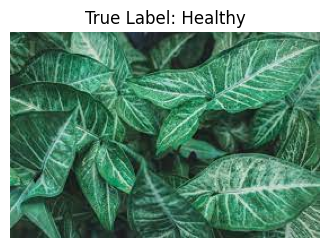

In [ ]:
img = cv2.imread('/content/download.jpeg')
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f'True Label: {true_label}')
plt.axis('off')
plt.show()


Making the test image go through the same preprocessing steps

1/1 [==============================] - 0s 37ms/step


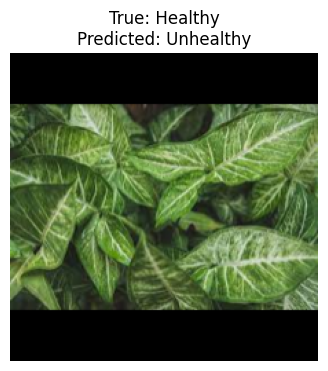

In [ ]:
import cv2
import numpy as np

image_path = '/content/download.jpeg'
img = cv2.imread(image_path)


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_height, img_width = img.shape[:2]
target_size = 224

aspect = img_width / img_height

if img_height > img_width:
    new_height = target_size
    new_width = int(round(target_size * aspect))
else:
    new_width = target_size
    new_height = int(round(target_size / aspect))

resize_factor = math.sqrt(
    (img_width**2 + img_height**2) / (new_width**2 + new_height**2)
)

img = cv2.resize(img, (new_width, new_height))

pad_x = target_size - new_width
pad_y = target_size - new_height

pad_top, pad_bottom = [int(i) for i in np.floor([pad_y, pad_y]) / 2]
pad_left, pad_right = [int(i) for i in np.floor([pad_x, pad_x]) / 2]

img = cv2.copyMakeBorder(
    img,
    pad_top,
    pad_bottom,
    pad_left,
    pad_right,
    cv2.BORDER_CONSTANT,
    value=[0, 0, 0],
)

img = cv2.resize(img, (target_size, target_size))

true_label = 'Healthy'


image = img / 255.0


prediction = model.predict(np.expand_dims(image, axis=0))
predicted_class = 'Healthy' if prediction[0][0] > 0.5 else 'Unhealthy'


plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(f'True: {true_label}\nPredicted: {predicted_class}')
plt.axis('off')
plt.show()


### Due to overfitting it is unable to predict properly on unseen data like in this case so we implement a series of models and try to predict with an ensemble apporach

## Model 2: Inception V3

In [ ]:
from tensorflow.keras.applications import InceptionV3

inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in inception_model.layers:
    layer.trainable = False

model_inception = Sequential()
model_inception.add(inception_model)
model_inception.add(Flatten())
model_inception.add(Dense(256, activation='relu'))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(1, activation='sigmoid'))

model_inception.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34910497 (133.17 MB)
Trainable params: 13107713 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
trained_inception = model_inception.fit(
    train_datagen,
    steps_per_epoch=len(train_images) // 32,
    epochs=20,
    validation_data=val_datagen,
    validation_steps=len(val_images) // 32,
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1
)


Epoch 1/20
24/24 [==============================] - 15s 629ms/step - loss: 0.1080 - accuracy: 0.9961 - val_loss: 1.1825e-33 - val_accuracy: 1.0000
Epoch 2/20
24/24 [==============================] - 13s 538ms/step - loss: 0.0016 - accuracy: 0.9987 - val_loss: 8.3227e-15 - val_accuracy: 1.0000
Epoch 3/20
24/24 [==============================] - 13s 536ms/step - loss: 0.0121 - accuracy: 0.9987 - val_loss: 0.0282 - val_accuracy: 0.9948
Epoch 4/20
24/24 [==============================] - 15s 636ms/step - loss: 0.2042 - accuracy: 0.9883 - val_loss: 0.2058 - val_accuracy: 0.9896


In [ ]:


predictions = model_inception.predict(val_datagen)

binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]


accuracy = accuracy_score(val_labels, binary_predictions)
precision = precision_score(val_labels, binary_predictions)
recall = recall_score(val_labels, binary_predictions)
f1 = f1_score(val_labels, binary_predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

6/6 [==============================] - 4s 354ms/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [ ]:
!pip install efficientnet

## Model 3 : EfficientNet

In [ ]:
from efficientnet.tfkeras import EfficientNetB0

efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in efficientnet_model.layers:
    layer.trainable = False

model_efficientnet = Sequential()
model_efficientnet.add(efficientnet_model)
model_efficientnet.add(Flatten())
model_efficientnet.add(Dense(256, activation='relu'))
model_efficientnet.add(Dropout(0.5))
model_efficientnet.add(Dense(1, activation='sigmoid'))

model_efficientnet.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model_efficientnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               16056576  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20106397 (76.70 MB)
Trainable params: 16056833 (61.25 MB)
Non-trainable params: 4049564 (15.45 MB)
_______

In [ ]:
trained_efficientnet = model_efficientnet.fit(
    train_datagen,
    steps_per_epoch=len(train_images) // 32,
    epochs=20,
    validation_data=val_datagen,
    validation_steps=len(val_images) // 32,
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1
)

Epoch 1/20
24/24 [==============================] - 36s 811ms/step - loss: 0.4682 - accuracy: 0.9388 - val_loss: 4.7610e-18 - val_accuracy: 1.0000
Epoch 2/20
24/24 [==============================] - 11s 465ms/step - loss: 1.1314e-14 - accuracy: 1.0000 - val_loss: 1.8273e-33 - val_accuracy: 1.0000
Epoch 3/20
24/24 [==============================] - 12s 490ms/step - loss: 0.0267 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
24/24 [==============================] - 13s 528ms/step - loss: 0.0245 - accuracy: 0.9987 - val_loss: 2.2284e-34 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 12s 523ms/step - loss: 4.8384e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
24/24 [==============================] - 13s 545ms/step - loss: 8.1636e-15 - accuracy: 1.0000 - val_loss: 2.1897e-30 - val_accuracy: 1.0000


In [ ]:

val_images = np.array(val_images) / 255.0

predictions = model_efficientnet.predict(val_datagen)

binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]


accuracy = accuracy_score(val_labels, binary_predictions)
precision = precision_score(val_labels, binary_predictions)
recall = recall_score(val_labels, binary_predictions)
f1 = f1_score(val_labels, binary_predictions)
print("Accuracy of EfficientNet model")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

6/6 [==============================] - 3s 346ms/step
Accuracy of EfficientNet model
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


## Model 4: ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    layer.trainable = False

model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Flatten())
model_resnet.add(Dense(256, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(1, activation='sigmoid'))

model_resnet.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model_resnet.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49278337 (187.98 MB)
Trainable params: 25690625 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
trained_resnet = model_resnet.fit(
    train_datagen,
    steps_per_epoch=len(train_images) // 32,
    epochs=20,
    validation_data=val_datagen,
    validation_steps=len(val_images) // 32,
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1
)

Epoch 1/20
24/24 [==============================] - 21s 603ms/step - loss: 5.5642 - accuracy: 0.5612 - val_loss: 0.7430 - val_accuracy: 0.7500
Epoch 2/20
24/24 [==============================] - 14s 578ms/step - loss: 0.6274 - accuracy: 0.7448 - val_loss: 0.3289 - val_accuracy: 0.9062
Epoch 3/20
24/24 [==============================] - 16s 659ms/step - loss: 0.3618 - accuracy: 0.8464 - val_loss: 0.2346 - val_accuracy: 0.9219
Epoch 4/20
24/24 [==============================] - 16s 658ms/step - loss: 0.3517 - accuracy: 0.8555 - val_loss: 0.2240 - val_accuracy: 0.9427
Epoch 5/20
24/24 [==============================] - 13s 541ms/step - loss: 0.3199 - accuracy: 0.8607 - val_loss: 0.2503 - val_accuracy: 0.9271
Epoch 6/20
24/24 [==============================] - 15s 629ms/step - loss: 0.3568 - accuracy: 0.8307 - val_loss: 0.2300 - val_accuracy: 0.9635
Epoch 7/20
24/24 [==============================] - 12s 503ms/step - loss: 0.2938 - accuracy: 0.8776 - val_loss: 0.1629 - val_accuracy: 0.9531

In [ ]:


predictions = model_resnet.predict(val_datagen)

binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]


accuracy = accuracy_score(val_labels, binary_predictions)
precision = precision_score(val_labels, binary_predictions)
recall = recall_score(val_labels, binary_predictions)
f1 = f1_score(val_labels, binary_predictions)
print("Accuracy of ResNet model")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

6/6 [==============================] - 3s 352ms/step
Accuracy of ResNet model
Accuracy: 0.9948
Precision: 1.0000
Recall: 0.9896
F1 Score: 0.9948


## Now using the ensemble approach to predict

In [ ]:


# Making predictions using each individual model on the validation set
predictions_vgg = model.predict(val_datagen)
predictions_resnet = model_resnet.predict(val_datagen)
predictions_inception = model_inception.predict(val_datagen)
predictions_efficientnet = model_efficientnet.predict(val_datagen)

# Combining predictions from individual models into an ensemble
ensemble_predictions = (predictions_vgg + predictions_resnet + predictions_inception + predictions_efficientnet) / 4


ensemble_labels = [1 if pred >= 0.5 else 0 for pred in ensemble_predictions]

true_labels = val_labels

ensemble_accuracy = accuracy_score(true_labels, ensemble_labels)
print(f"Ensemble Accuracy: {ensemble_accuracy}")


6/6 [==============================] - 2s 335ms/step
Ensemble Accuracy: 1.0


## Trying our ensemble model on the same image that was predicted incorrectly

1/1 [==============================] - 0s 43ms/step


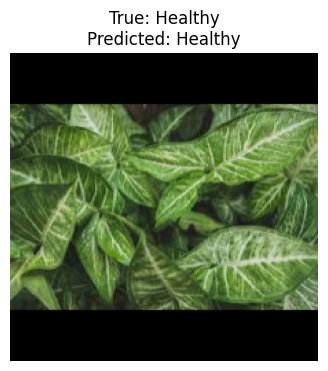

In [ ]:


image_path = '/content/download.jpeg'
img = cv2.imread(image_path)


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_height, img_width = img.shape[:2]
target_size = 224

aspect = img_width / img_height

if img_height > img_width:
    new_height = target_size
    new_width = int(round(target_size * aspect))
else:
    new_width = target_size
    new_height = int(round(target_size / aspect))

resize_factor = math.sqrt(
    (img_width**2 + img_height**2) / (new_width**2 + new_height**2)
)

img = cv2.resize(img, (new_width, new_height))

pad_x = target_size - new_width
pad_y = target_size - new_height

pad_top, pad_bottom = [int(i) for i in np.floor([pad_y, pad_y]) / 2]
pad_left, pad_right = [int(i) for i in np.floor([pad_x, pad_x]) / 2]

img = cv2.copyMakeBorder(
    img,
    pad_top,
    pad_bottom,
    pad_left,
    pad_right,
    cv2.BORDER_CONSTANT,
    value=[0, 0, 0],
)

img = cv2.resize(img, (target_size, target_size))

true_label = 'Healthy'


image = img / 255.0


prediction = model.predict(np.expand_dims(image, axis=0))
predicted_class = 'Healthy' if prediction[0][0] < 0.5 else 'Unealthy'


plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(f'True: {true_label}\nPredicted: {predicted_class}')
plt.axis('off')
plt.show()


## Trying our ensemble model on a different random image taken from internet

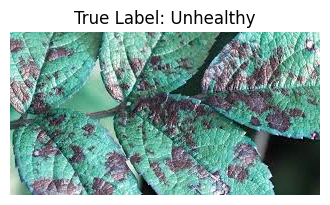

In [ ]:
import matplotlib.pyplot as plt
true_label="Unhealthy"
img = cv2.imread('/content/images.jpeg')
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f'True Label: {true_label}')
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 20ms/step


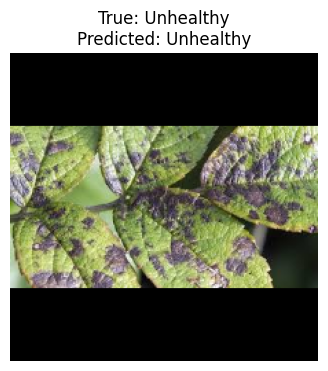

In [ ]:

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_height, img_width = img.shape[:2]
target_size = 224

aspect = img_width / img_height

if img_height > img_width:
    new_height = target_size
    new_width = int(round(target_size * aspect))
else:
    new_width = target_size
    new_height = int(round(target_size / aspect))

resize_factor = math.sqrt(
    (img_width**2 + img_height**2) / (new_width**2 + new_height**2)
)

img = cv2.resize(img, (new_width, new_height))

pad_x = target_size - new_width
pad_y = target_size - new_height

pad_top, pad_bottom = [int(i) for i in np.floor([pad_y, pad_y]) / 2]
pad_left, pad_right = [int(i) for i in np.floor([pad_x, pad_x]) / 2]

img = cv2.copyMakeBorder(
    img,
    pad_top,
    pad_bottom,
    pad_left,
    pad_right,
    cv2.BORDER_CONSTANT,
    value=[0, 0, 0],
)

img = cv2.resize(img, (target_size, target_size))



image = img / 255.0


prediction = model.predict(np.expand_dims(image, axis=0))
predicted_class = 'Healthy' if prediction[0][0] > 0.5 else 'Unhealthy'


plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(f'True: {true_label}\nPredicted: {predicted_class}')
plt.axis('off')
plt.show()


## The ensemble technique was a success as now test images are being classified correctly